In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Параметры отображения графиков:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams.update({'font.size': 10})

In [3]:
# Исходные данные
data = pd.read_csv('survey_results_public.csv')

In [4]:
# Количество строк и столбцов
print(data.shape)

(64461, 61)


# Функции

In [5]:
def draw_piechart(values, labels, cat: str):
    """Функция отображает круговую диаграмму на основе
    абсолютных значений values по категориям labels."""
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(f'Распределение респондентов в категории {cat}')
    plt.tight_layout()
    plt.show()

In [6]:
def draw_barplot(values, labels, cat: str):
    """Функция отображает столбчатую диаграмму с процентными
    значениями values по категориям labels."""
    plt.barh(labels, values)
    plt.title(f'Доля респондентов в категории {cat}')
    plt.tight_layout()
    plt.show()

In [7]:
def sort_unique_answers(df: pd.DataFrame, cat: str, n_segments: int):
    """Функция находит распределение ответов респондентов
    в категории cat, где каждая ячейка имеет не более одного
    варианта ответа, и отображает круговую диаграмму
    для крупнейших групп с учетом параметра n_segments."""
    # Группировка заполненных значений столбца
    by_groups = df.loc[~df[cat].isna(), cat].value_counts()
    # Группа "прочие" для категорий, не входящих в крупнейшие n_segments
    others_group = by_groups.iloc[n_segments:].sum()
    by_groups = by_groups.iloc[:n_segments]
    # Значения и подписи секторов для диаграммы
    labels = by_groups.index.to_list()
    labels.append('Other')
    values = by_groups.to_list()
    values.append(others_group)
    # Визуализация
    draw_piechart(values, labels, cat)

In [8]:
def sort_multiple_answers(df: pd.DataFrame, cat: str, n_segments: int):
    """Функция находит распределение ответов респондентов
    в категории cat с множественными вариантами ответов,
    разделенными ';', и отображает круговую диаграмму
    для крупнейших групп с учетом параметра n_segments.
    """
    distribution = df.loc[~data[cat].isna(), cat]  # Убираем пропуски
    n_respondents = len(distribution)  # Количество ответивших респондентов
    # Преобразуем столбец датафрейма, содержащий строки с разделителями,
    # в словарь с количеством ответов по каждому варианту
    dist_dict = Counter()
    distribution.apply(lambda x: dist_dict.update(x.split(';')))
    distribution = pd.DataFrame.from_dict(dist_dict, orient='index').sort_values(by=0, ascending=False)
    # Группа "прочие" для категорий, не входящих в крупнейшие n_segments
    others_group = distribution.iloc[n_segments:, 0].sum()
    distribution = distribution.iloc[:n_segments, 0]
    # Делим количество в каждой категории на числов респондентов
    distribution = distribution / n_respondents
    others_group /= n_respondents
    # Значения и подписи секторов для диаграммы
    labels = distribution.index.to_list()
    labels.append('Other')
    values = distribution.to_list()
    values.append(others_group)
    # Визуализация
    draw_barplot(values, labels, cat)

In [9]:
def draw_hist(data, cat: str):
    """Функция выводит гистограмму значений в категории cat."""
    plt.hist(data)
    plt.title(f'Распределение в категории {cat}')
    plt.tight_layout()
    plt.show()

In [10]:
def text_to_number(df: pd.DataFrame, cat: str):
    """Функция преобразует значения столбца, содержащего смешанные
    числовые и текстовые значения к числовым значениям."""
    df[cat] = df[cat].apply(
        lambda x: 0.5 if x == 'Less than 1 year'
        else (51 if x == 'More than 50 years' else int(x)))
    return df[cat]

In [11]:
def sort_continuous_values(df: pd.DataFrame, cat: str, bins: list, mixed=False):
    """Функция преобразует столбец с числовыми данными в категорийный,
    разбивая значения по интервалам в списке bins и выводит круговую диаграмму.
    Если bins содержит пустой список, выводит гистограмму распределения значений.
    """
    df.dropna(subset=[cat], inplace=True)  # Удаляем пропуски
    # Если указаны границы интервалов значений
    if bins:
        labels = []  # Список подписей к группам
        for i in range(1, len(bins)):
            label = f'{str(bins[i - 1])}-{str(bins[i])}'
            labels.append(label)
        # Преобразуем числовые значения в категорийные
        categories = pd.cut(df[cat], bins=bins, labels=labels)
        # Подсчитываем количество по категориям
        categories = categories.value_counts()
        labels = categories.index.to_list()
        values = categories.to_list()
        # Визуализация
        draw_piechart(values, labels, cat)
    else:  # Если bins=[]
        if mixed:  # Если в столбце смешанные значения
            df[cat] = text_to_number(df, cat)
        # Визуализация
        draw_hist(df[cat], cat)

In [12]:
def income_by_cat(df: pd.DataFrame, cat: str):
    """Функция выводит график зависимости среднего уровня дохода
    от значения категорийного столбца cat."""
    median_income = df['ConvertedComp'].median()
    income_by_cat = df[['ConvertedComp', cat]].groupby(cat).mean().round(0) \
        .sort_values('ConvertedComp', ascending=False).dropna()
    # ТОП-20 значений
    x_vals = income_by_cat.head(20).index
    y_vals = income_by_cat['ConvertedComp'].head(20).values
    # Визуализация
    plt.barh(x_vals, y_vals)
    plt.axvline(median_income, color='r', label='Медиана')
    plt.legend()
    plt.title(f'Уровень дохода, USD')
    plt.tight_layout()
    plt.show()

In [13]:
def income_correlation(df: pd.DataFrame, cat: str, mixed=False):
    """Функция выводит график зависимости уровня дохода
    от числового параметра cat."""
    median_income = df['ConvertedComp'].median()
    df.dropna(subset=['ConvertedComp', cat], inplace=True)
    if mixed:  # Если в столбце смешанные значения
        df[cat] = text_to_number(df, cat)
    x_vals = df[cat].values
    y_vals = df['ConvertedComp'].values
    min_x = df[cat].min()
    max_x = df[cat].max()
    # Визуализация
    plt.scatter(x_vals, y_vals)
    plt.hlines(median_income, min_x, max_x,
               colors='red', label='Медиана')
    plt.legend()
    plt.xlabel(cat)
    plt.title(f'Уровень дохода, USD')
    plt.tight_layout()
    plt.show()

In [14]:
def income_impact(df: pd.DataFrame, cat: str, skill: str):
    """Функция выводит график со средним уровенем дохода
    в зависимости от наличия или отсутствия указанного skill
    в перечне ответов респондента в категории cat."""
    df.dropna(subset=['ConvertedComp', cat], inplace=True)
    mask = df[cat].str.contains(skill)
    income_with_skill = df.loc[mask, 'ConvertedComp'].mean()
    income_without_skill = df.loc[~mask, 'ConvertedComp'].mean()
    plt.bar([skill, f'no {skill}'], [income_with_skill, income_without_skill])
    plt.title(f'Уровень дохода, USD')
    plt.tight_layout()
    plt.show()

# Анализ данных и визуализация

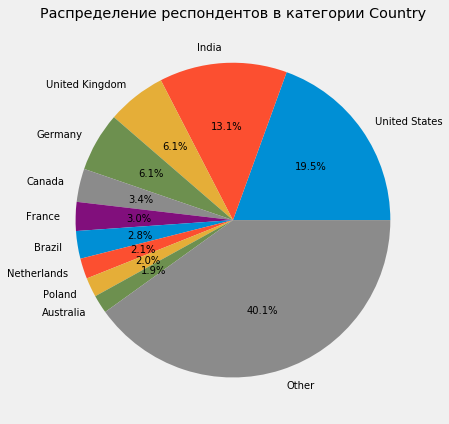

In [15]:
# Распределение респондентов по странам для ТОП-10
sort_unique_answers(data, cat='Country', n_segments=10)

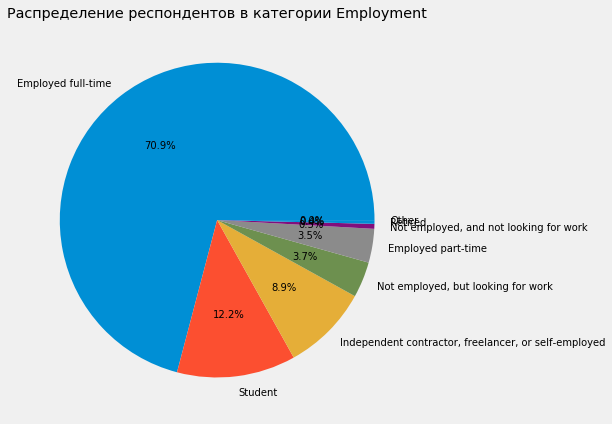

In [16]:
# Распределение респондентов по типу занятости (отображаем все группы, их меньше 10-ти)
sort_unique_answers(data, cat='Employment', n_segments=10)

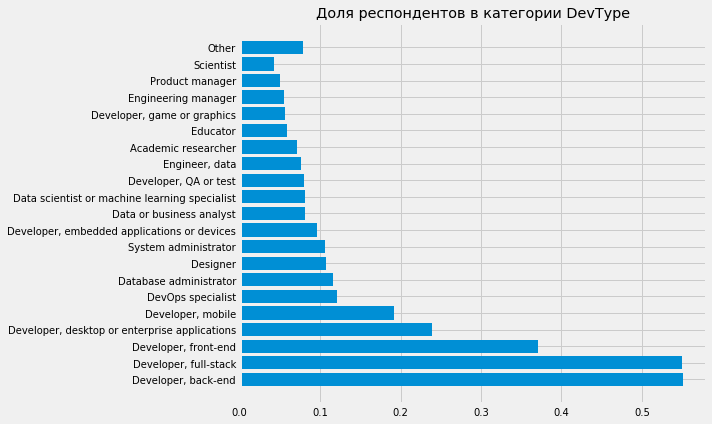

In [17]:
# Распределение респондентов по специализации для ТОП-20
sort_multiple_answers(data, cat='DevType', n_segments=20)

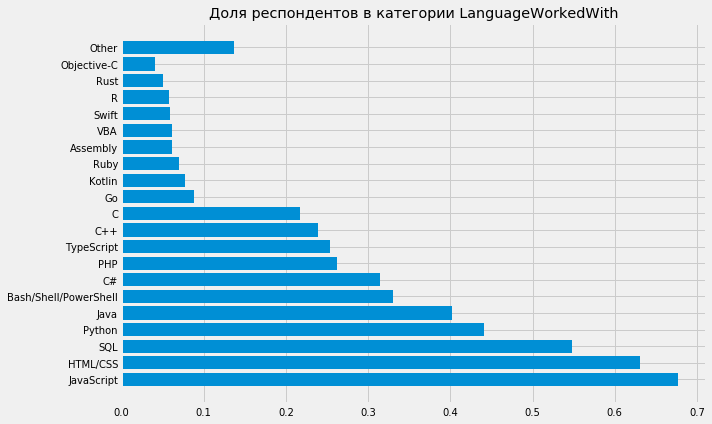

In [18]:
# Распределение респондентов по языку программирования
sort_multiple_answers(data, cat='LanguageWorkedWith', n_segments=20)

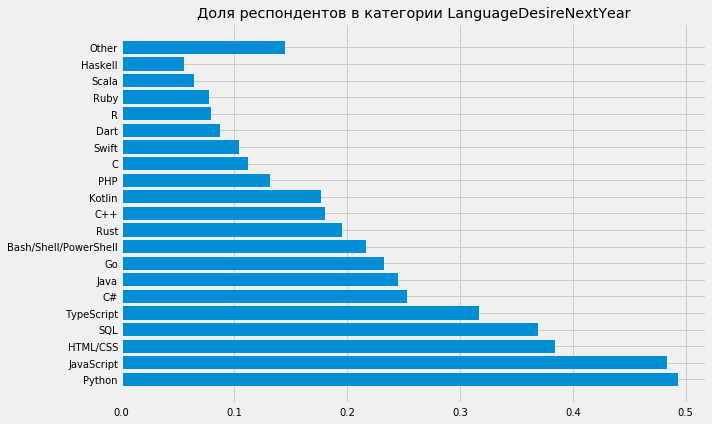

In [19]:
# Распределение респондентов по языку программирования, который планируют изучить
sort_multiple_answers(data, cat='LanguageDesireNextYear', n_segments=20)

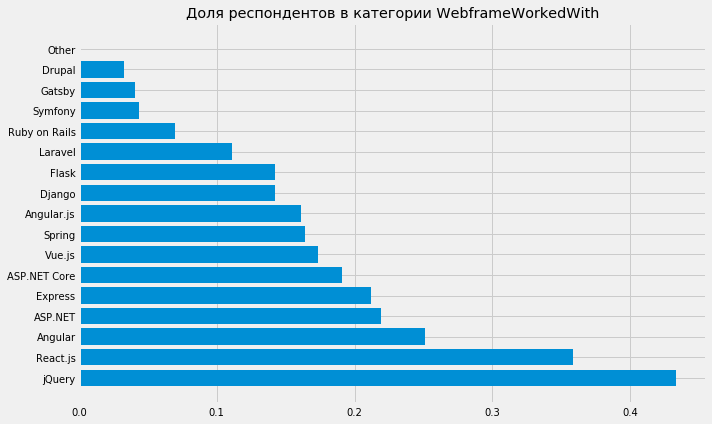

In [20]:
# Распределение респондентов по веб-фреймворкам
sort_multiple_answers(data, cat='WebframeWorkedWith', n_segments=20)

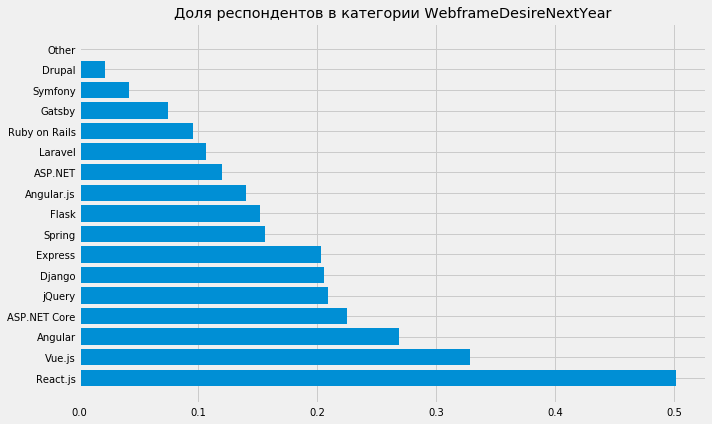

In [21]:
# Распределение респондентов по веб-фреймворкам, которые планируют изучить
sort_multiple_answers(data, cat='WebframeDesireNextYear', n_segments=20)

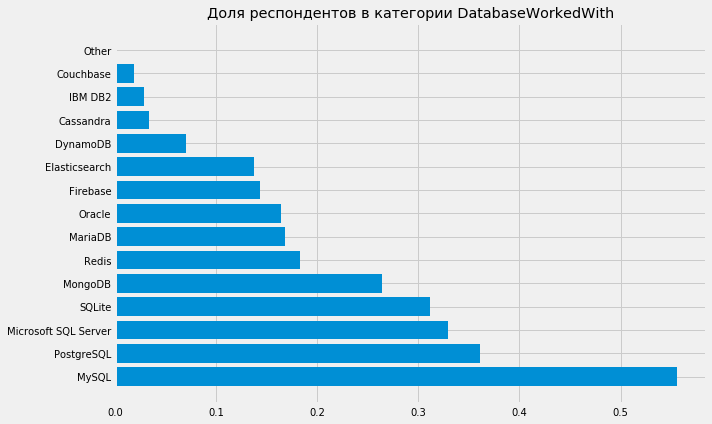

In [22]:
# Распределение респондентов по видам баз данных
sort_multiple_answers(data, cat='DatabaseWorkedWith', n_segments=20)

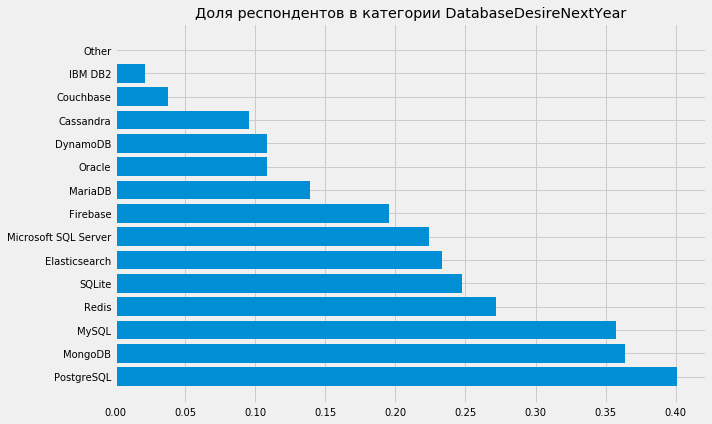

In [23]:
# Распределение респондентов по видам баз данных, которые планируют изучить
sort_multiple_answers(data, cat='DatabaseDesireNextYear', n_segments=20)

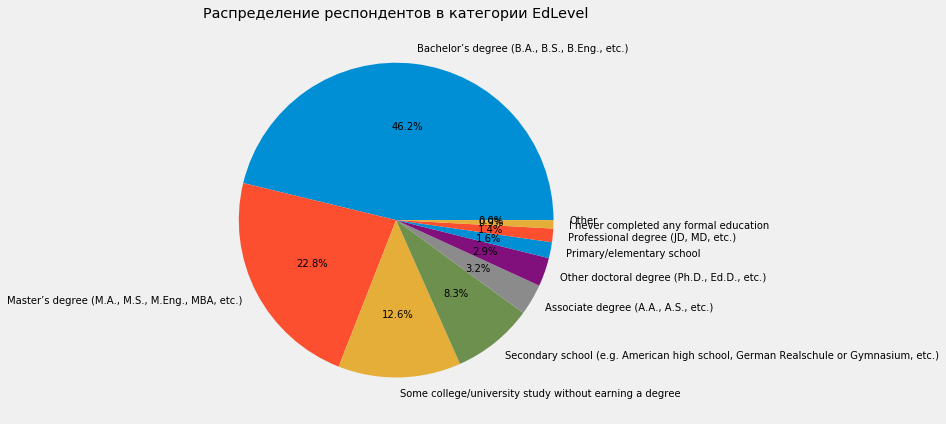

In [24]:
# Распределение респондентов по уровню образования
sort_unique_answers(data, cat='EdLevel', n_segments=10)

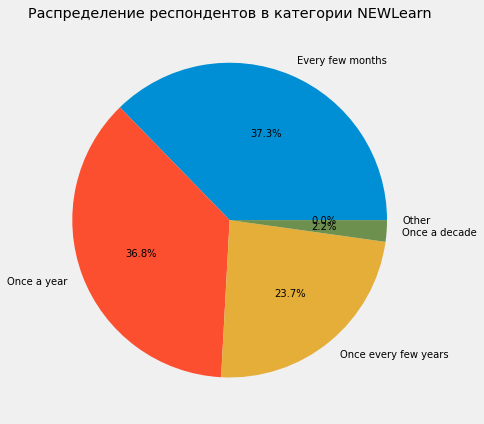

In [25]:
# Распределение респондентов по периодичности обучения
sort_unique_answers(data, cat='NEWLearn', n_segments=10)

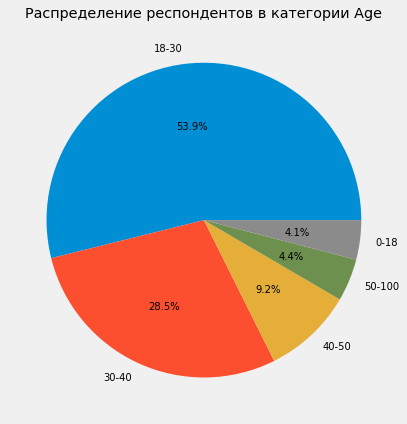

In [26]:
# Распределение респондентов по возрастным группам с учетом указанных диапазонов
sort_continuous_values(data, cat='Age', bins=[0, 18, 30, 40, 50, 100])

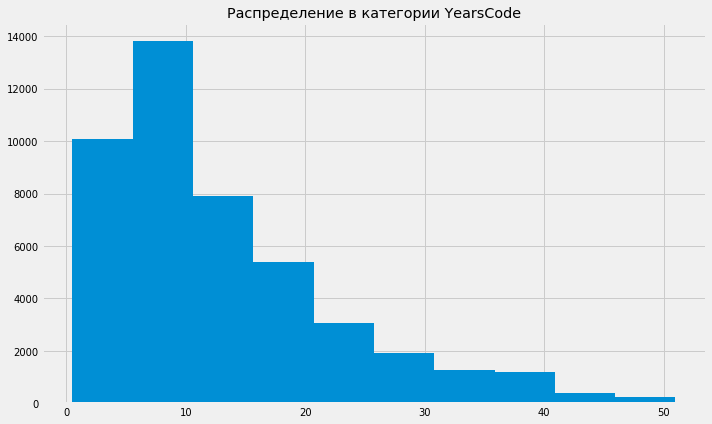

In [27]:
# Распределение респондентов по опыту в программировании
sort_continuous_values(data, cat='YearsCode', bins=[], mixed=True)

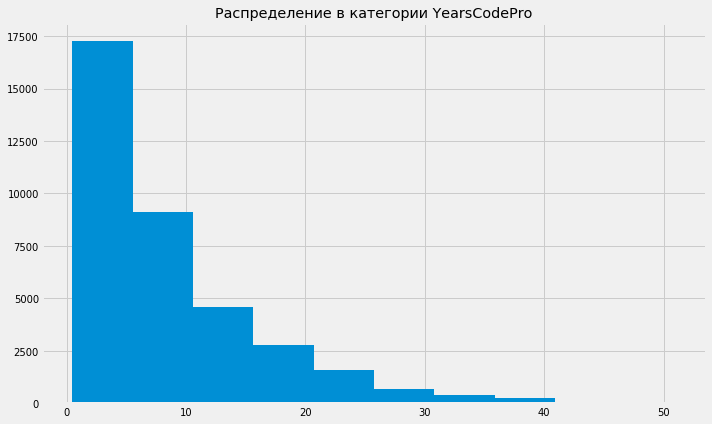

In [28]:
# Распределение респондентов по опыту профессиональной деятельности
sort_continuous_values(data, cat='YearsCodePro', bins=[], mixed=True)

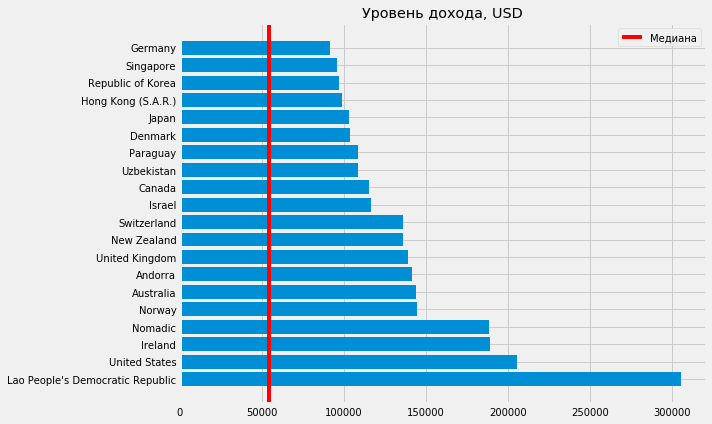

In [29]:
# Средний уровень дохода в зависимости от категорийныйх параметров
income_by_cat(data, cat='Country')

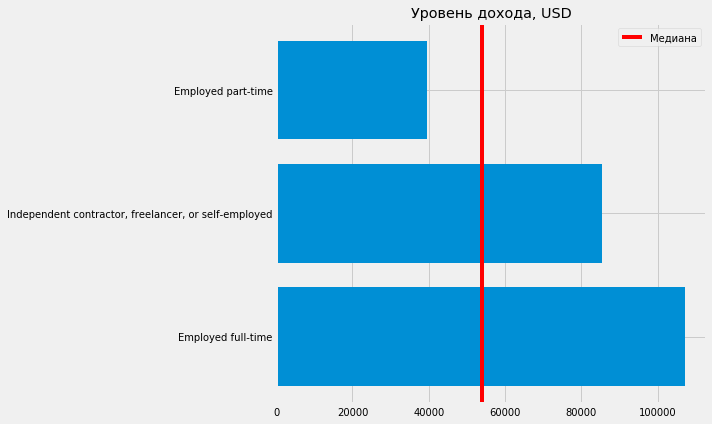

In [30]:
income_by_cat(data, cat='Employment')

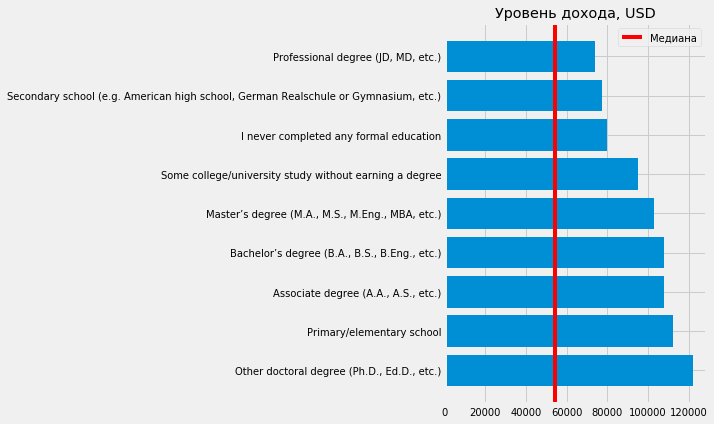

In [31]:
income_by_cat(data, cat='EdLevel')

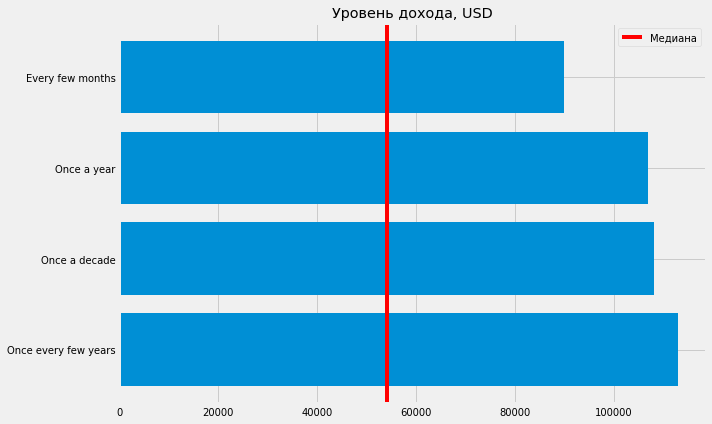

In [32]:
income_by_cat(data, cat='NEWLearn')

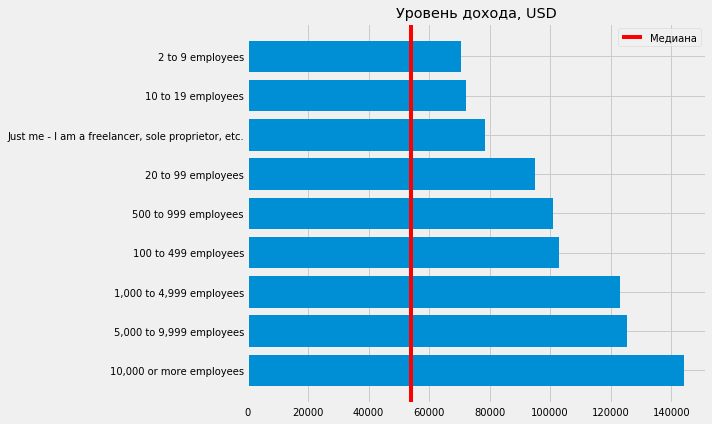

In [33]:
income_by_cat(data, cat='OrgSize')

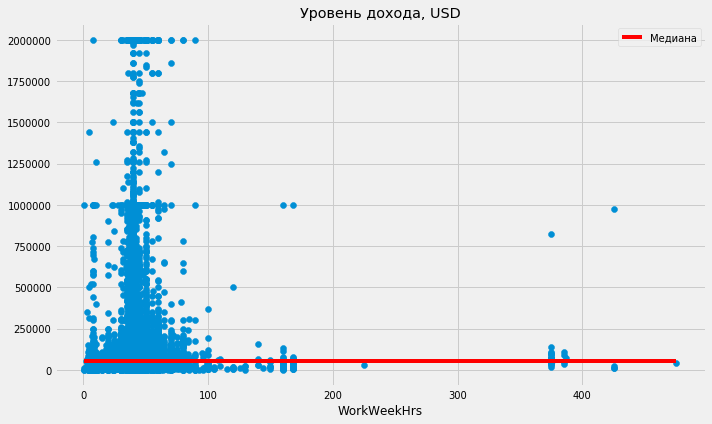

In [34]:
# Зависимость уровня дохода от числовых параметров
income_correlation(data, cat='WorkWeekHrs')

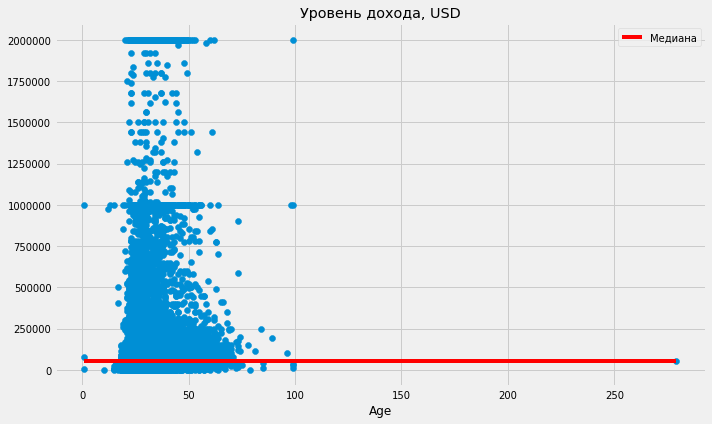

In [35]:
income_correlation(data, cat='Age')

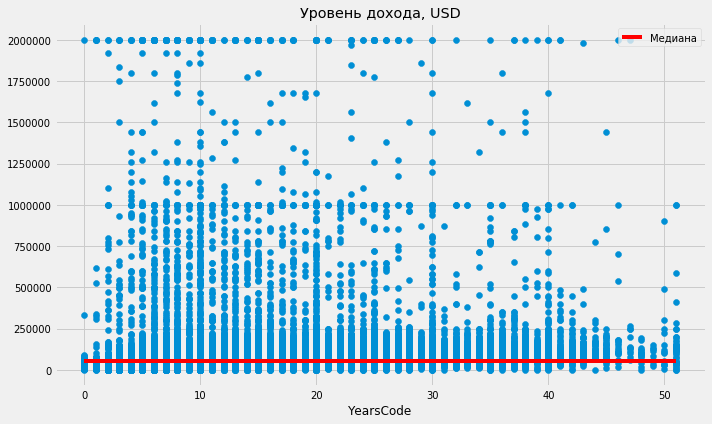

In [36]:
income_correlation(data, cat='YearsCode', mixed=True)

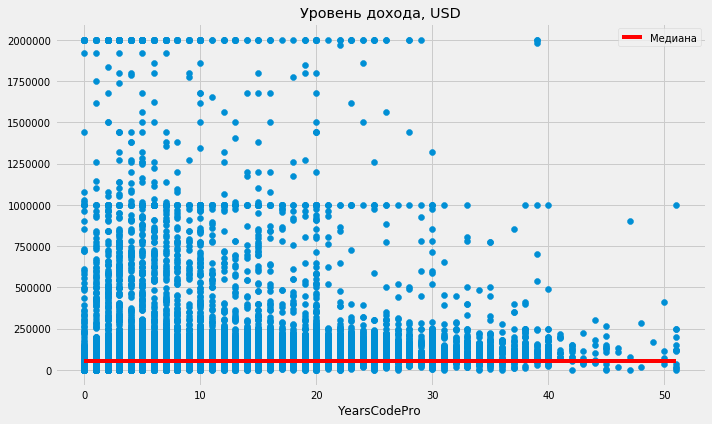

In [37]:
income_correlation(data, cat='YearsCodePro', mixed=True)

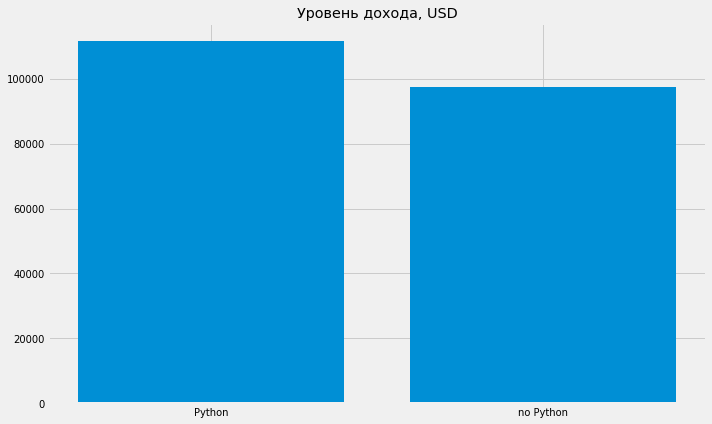

In [38]:
# Влияние технологий на уровень дохода
income_impact(data, cat='LanguageWorkedWith', skill='Python')

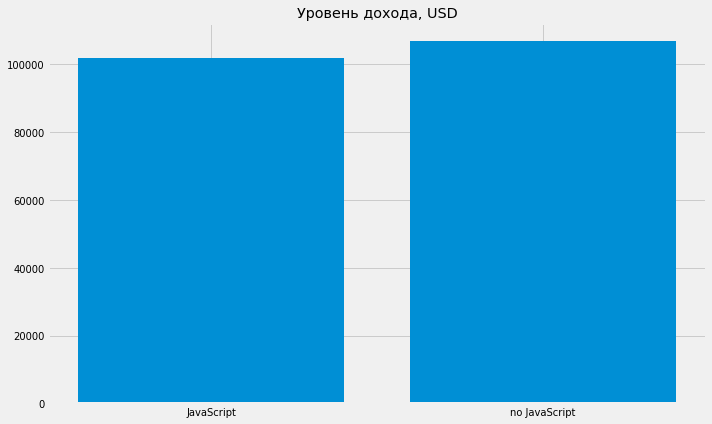

In [39]:
income_impact(data, cat='LanguageWorkedWith', skill='JavaScript')

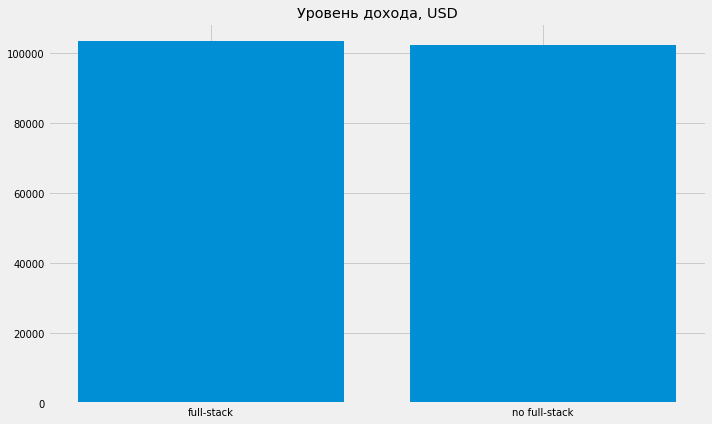

In [40]:
income_impact(data, cat='DevType', skill='full-stack')

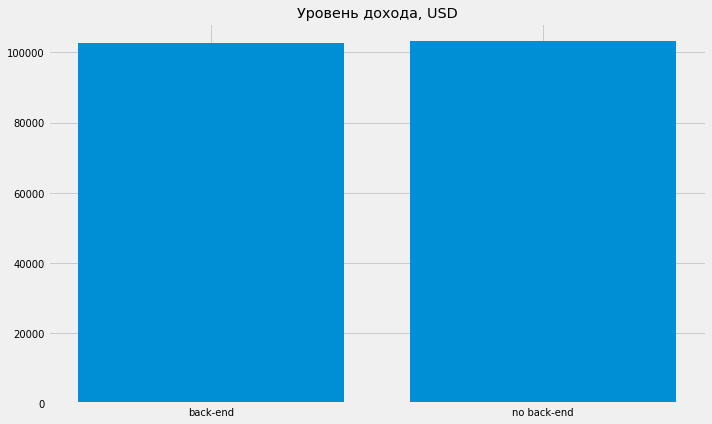

In [41]:
income_impact(data, cat='DevType', skill='back-end')

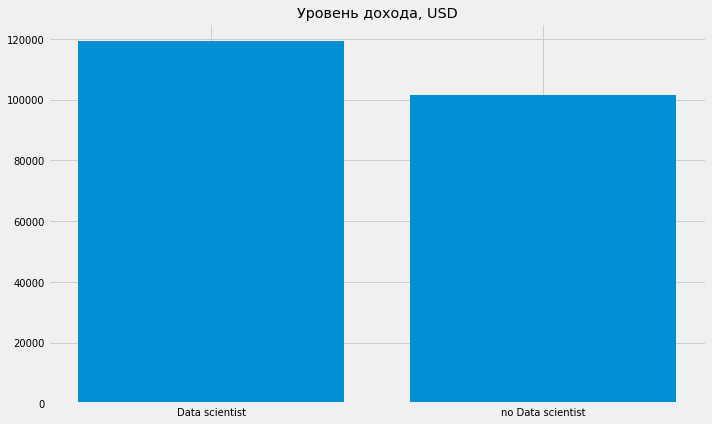

In [42]:
income_impact(data, cat='DevType', skill='Data scientist')

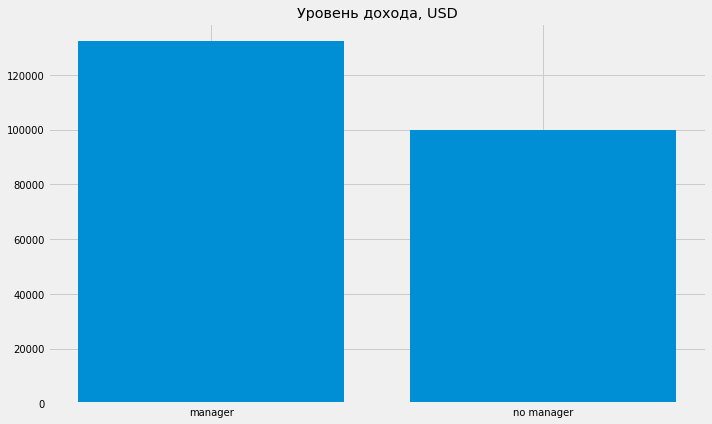

In [43]:
income_impact(data, cat='DevType', skill='manager')

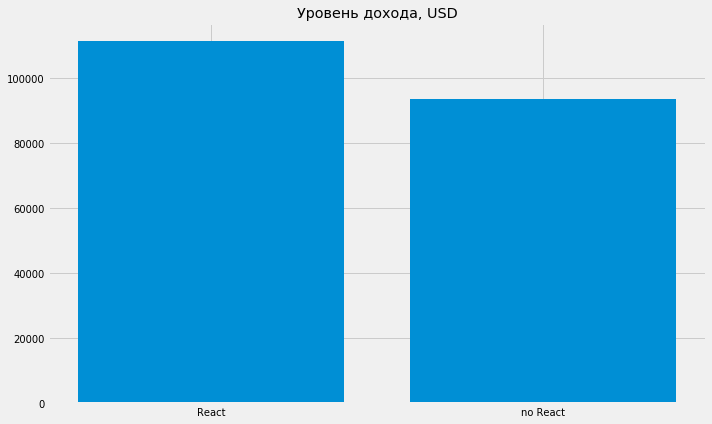

In [44]:
income_impact(data, cat='WebframeWorkedWith', skill='React')

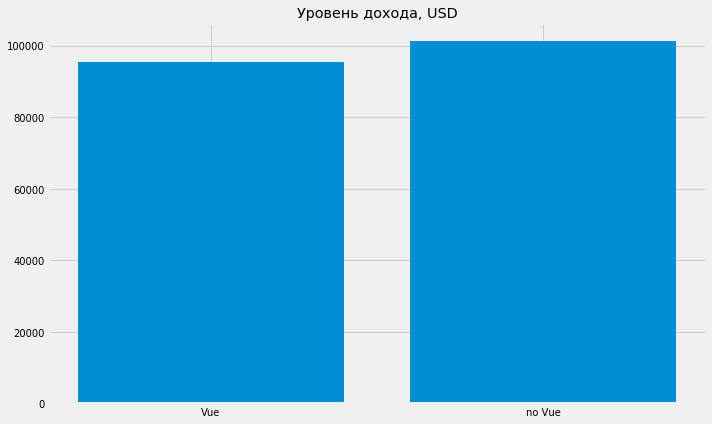

In [45]:
income_impact(data, cat='WebframeWorkedWith', skill='Vue')

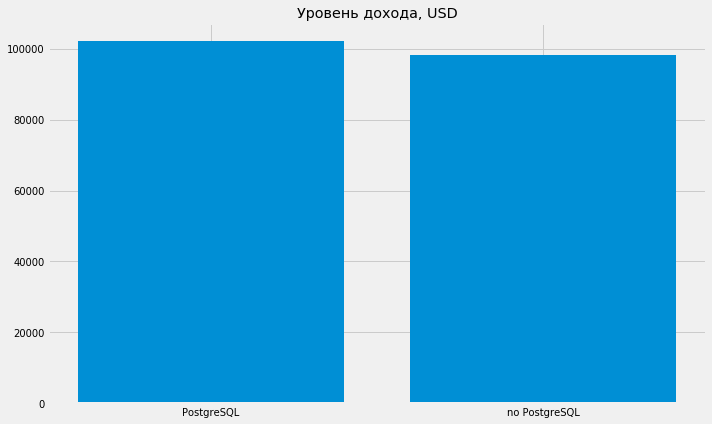

In [46]:
income_impact(data, cat='DatabaseWorkedWith', skill='PostgreSQL')